# QAOA with Circuit Cutting

In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import networkx as nx
import time
from qiskit_optimization.applications import Maxcut
# General imports
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz

from qiskit import transpile
from qiskit_aer import AerSimulator
# from qiskit.visualization import plot_distribution
#from qiskit.quantum_info import SparsePauliOp
# Qiskit Runtime
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram 



### Helper Functions

In [2]:

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

### Make the Graph

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



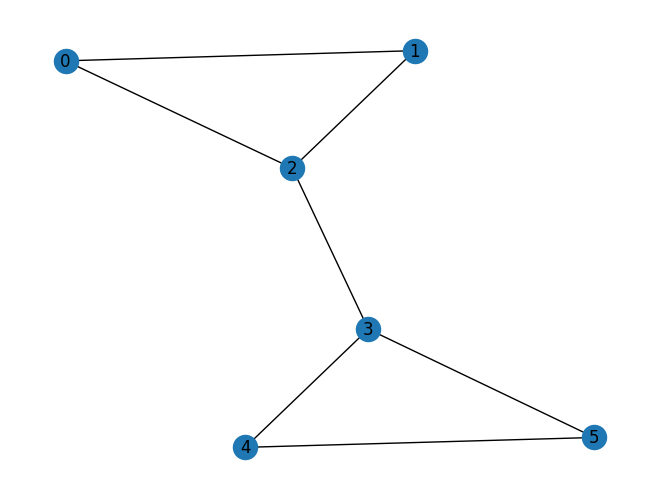

In [3]:
num_nodes = 6



# G = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
# nx.draw(G, with_labels=True, pos=nx.spring_layout(G, seed=seed))


G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,0),(3,2),(4,3),(5,3),(4,5)])
nx.draw_spring(G, with_labels=True)
maxcut = Maxcut(G)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

The weight Matrix

In [4]:
# Initialize the weight matrix
w = np.zeros((num_nodes, num_nodes))

# Iterate over the edges of the graph and assign weights to the weight matrix
for edge in G.edges():
    node1, node2 = edge
    w[node1][node2] = 1
    w[node2][node1] = 1  # Assuming undirected graph

# Print the weight matrix
#print("Weight Matrix:")
#print(w)

pos = nx.spring_layout(G)

## Brute Force


Best solution = [1, 0, 0, 1, 0, 0] cost = 5.0

Best solution = [0, 1, 0, 1, 0, 0] cost = 5.0

Best solution = [1, 1, 0, 1, 0, 0] cost = 5.0

Best solution = [0, 0, 1, 0, 1, 0] cost = 5.0

Best solution = [1, 0, 1, 0, 1, 0] cost = 5.0

Best solution = [0, 1, 1, 0, 1, 0] cost = 5.0

Best solution = [1, 0, 0, 1, 1, 0] cost = 5.0

Best solution = [0, 1, 0, 1, 1, 0] cost = 5.0

Best solution = [1, 1, 0, 1, 1, 0] cost = 5.0

Best solution = [0, 0, 1, 0, 0, 1] cost = 5.0

Best solution = [1, 0, 1, 0, 0, 1] cost = 5.0

Best solution = [0, 1, 1, 0, 0, 1] cost = 5.0

Best solution = [1, 0, 0, 1, 0, 1] cost = 5.0

Best solution = [0, 1, 0, 1, 0, 1] cost = 5.0

Best solution = [1, 1, 0, 1, 0, 1] cost = 5.0

Best solution = [0, 0, 1, 0, 1, 1] cost = 5.0

Best solution = [1, 0, 1, 0, 1, 1] cost = 5.0

Best solution = [0, 1, 1, 0, 1, 1] cost = 5.0
elapsed time = 0.17801427841186523 sec


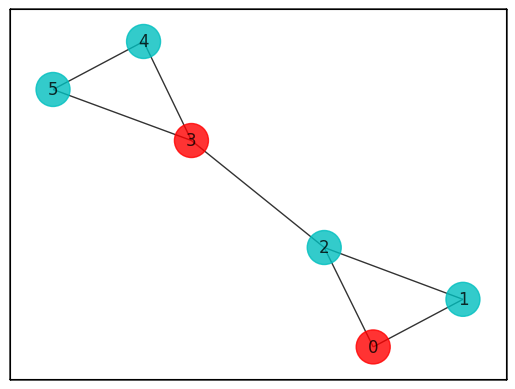

In [5]:
import itertools

tic = time.time()
best_cost_brute = 0
best_solutions_brute = []

for b in range(2 ** num_nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(num_nodes)))]
    cost = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            cost += w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        best_solutions_brute = [x]
    elif best_cost_brute == cost:
        best_solutions_brute.append(x)

    #print("case = " + str(x) + " cost = " + str(cost))

for solution in best_solutions_brute:
    colors = ["r" if solution[i] == 0 else "c" for i in range(num_nodes)]
    draw_graph(G, colors, pos)
    print("\nBest solution = " + str(solution) + " cost = " + str(best_cost_brute))

toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")



Best solution = [1, 0, 0, 1, 0, 0] cost = 5.0

Best solution = [0, 1, 0, 1, 0, 0] cost = 5.0

Best solution = [1, 1, 0, 1, 0, 0] cost = 5.0

Best solution = [0, 0, 1, 0, 1, 0] cost = 5.0

Best solution = [1, 0, 1, 0, 1, 0] cost = 5.0

Best solution = [0, 1, 1, 0, 1, 0] cost = 5.0

Best solution = [1, 0, 0, 1, 1, 0] cost = 5.0

Best solution = [0, 1, 0, 1, 1, 0] cost = 5.0

Best solution = [1, 1, 0, 1, 1, 0] cost = 5.0

Best solution = [0, 0, 1, 0, 0, 1] cost = 5.0

Best solution = [1, 0, 1, 0, 0, 1] cost = 5.0

Best solution = [0, 1, 1, 0, 0, 1] cost = 5.0

Best solution = [1, 0, 0, 1, 0, 1] cost = 5.0

Best solution = [0, 1, 0, 1, 0, 1] cost = 5.0

Best solution = [1, 1, 0, 1, 0, 1] cost = 5.0

Best solution = [0, 0, 1, 0, 1, 1] cost = 5.0

Best solution = [1, 0, 1, 0, 1, 1] cost = 5.0

Best solution = [0, 1, 1, 0, 1, 1] cost = 5.0
elapsed time = 0.18358778953552246 sec
All possible best solutions: [[1, 0, 0, 1, 0, 0], [0, 1, 0, 1, 0, 0], [1, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0], [1, 0

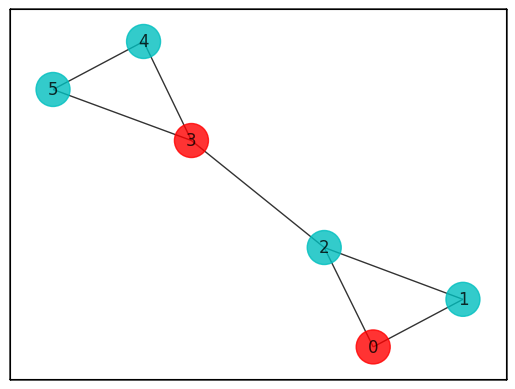

In [6]:
import itertools

tic = time.time()
best_cost_brute = 0
best_solutions_brute = []

for b in range(2 ** num_nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(num_nodes)))]
    cost = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            cost += w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        best_solutions_brute = [x]
    elif best_cost_brute == cost:
        best_solutions_brute.append(x)

    #print("case = " + str(x) + " cost = " + str(cost))

for solution in best_solutions_brute:
    colors = ["r" if solution[i] == 0 else "c" for i in range(num_nodes)]
    draw_graph(G, colors, pos)
    print("\nBest solution = " + str(solution) + " cost = " + str(best_cost_brute))

toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")

# Append all possible best solutions to a list
all_best_solutions = []
for b in range(2 ** num_nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(num_nodes)))]
    cost = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            cost += w[i, j] * x[i] * (1 - x[j])
    if cost == best_cost_brute:
        all_best_solutions.append(x)

print("All possible best solutions:", all_best_solutions)


In [7]:
print(all_best_solutions)

[[1, 0, 0, 1, 0, 0], [0, 1, 0, 1, 0, 0], [1, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0], [1, 0, 1, 0, 1, 0], [0, 1, 1, 0, 1, 0], [1, 0, 0, 1, 1, 0], [0, 1, 0, 1, 1, 0], [1, 1, 0, 1, 1, 0], [0, 0, 1, 0, 0, 1], [1, 0, 1, 0, 0, 1], [0, 1, 1, 0, 0, 1], [1, 0, 0, 1, 0, 1], [0, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1], [0, 0, 1, 0, 1, 1], [1, 0, 1, 0, 1, 1], [0, 1, 1, 0, 1, 1]]


## Running a circuit cut QAOA

In [8]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



In [9]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -3.5
Ising Hamiltonian:
SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


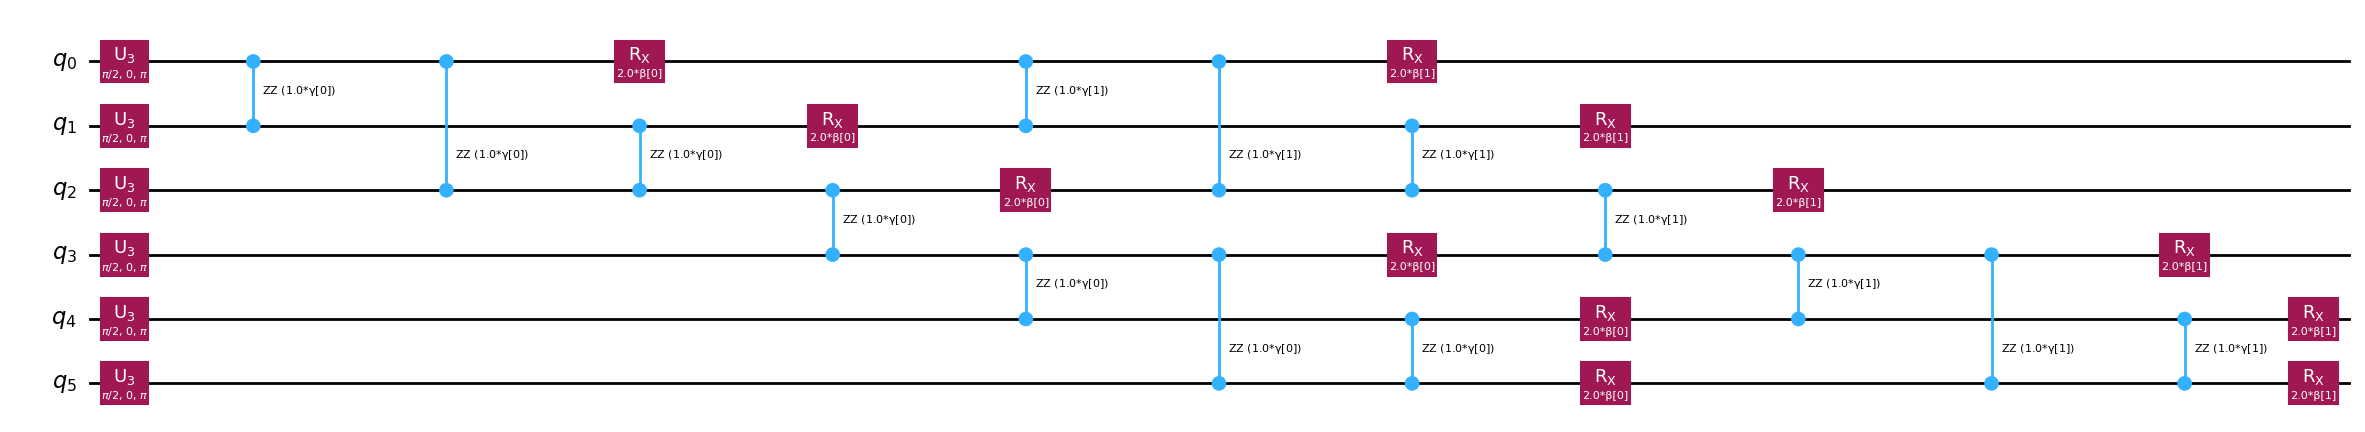

In [10]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(qubitOp, reps=2)

# the reps in decompose means, the number of times the circuit should be decomposed
# for example reps = 2 means circuit.decompise().decompose()
ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [11]:
print(f"Number of Qubits: {ansatz.num_qubits}")
print(f"Number of Parameters: {ansatz.num_parameters}")


Number of Qubits: 6
Number of Parameters: 4


In [12]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
print(x0)

[0.80097779 1.95117134 1.42340566 0.90112922]


# Wire Cutting

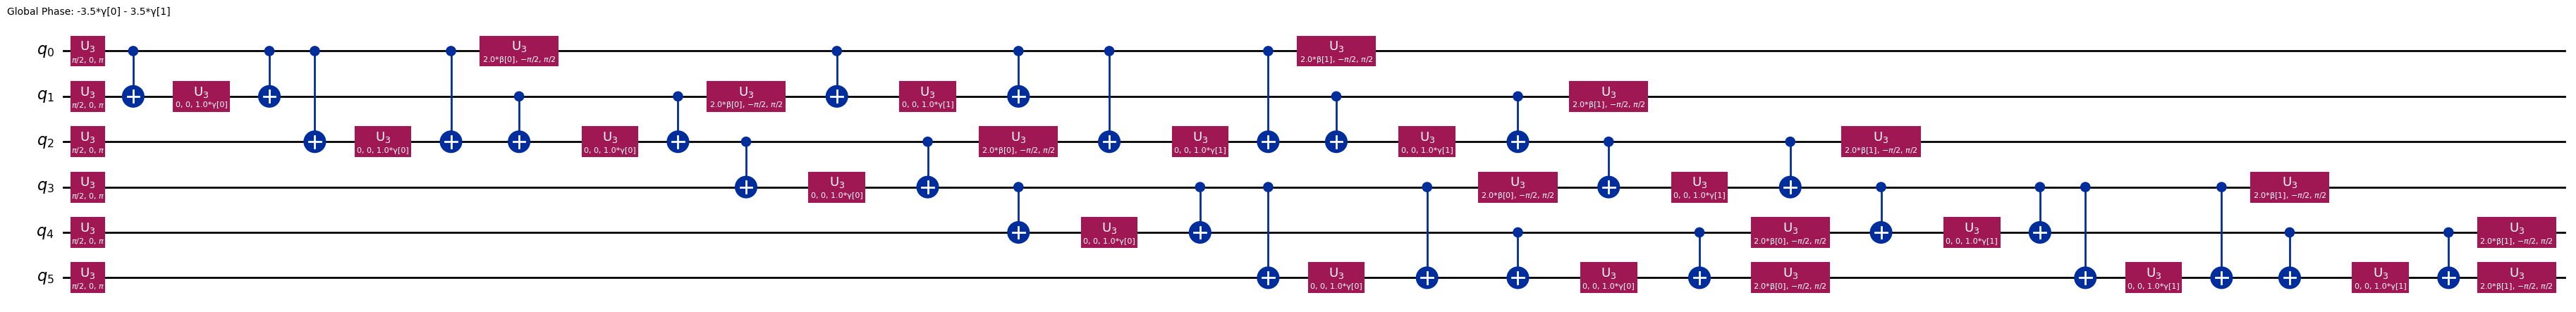

In [16]:
circuit_basis = transpile(ansatz, basis_gates=['u3', 'cx'], optimization_level=3)
circuit_basis.draw(output="mpl", style="iqp",fold=-1)

In [17]:
from circuit_knitting.cutting import partition_problem
from circuit_knitting.cutting.cut_finding.cco_utils import qc_to_cco_circuit
circuit_ckt = qc_to_cco_circuit(circuit_basis)

In [18]:
from qiskit.quantum_info import PauliList

observables_0 = PauliList(["ZZZZZZ"])

In [19]:
import numpy as np
from circuit_knitting.cutting.cut_finding.circuit_interface import SimpleGateList
from circuit_knitting.cutting.cut_finding.lo_cuts_optimizer import LOCutsOptimizer
from circuit_knitting.cutting.cut_finding.optimization_settings import (
    OptimizationSettings,
)
from circuit_knitting.cutting.cut_finding.quantum_device_constraints import (
    DeviceConstraints,
)

In [20]:
settings = OptimizationSettings(rand_seed=12345)

settings.set_engine_selection("CutOptimization", "BestFirst")


qubits_per_QPU = 4
num_QPUs = 2


for num_qpus in range(num_QPUs, 1, -1):
    for qpu_qubits in range(qubits_per_QPU, 1, -1):
        print(f"\n\n---------- {qpu_qubits} Qubits per QPU, {num_qpus} QPUs ----------")

        constraint_obj = DeviceConstraints(qubits_per_QPU=qpu_qubits, num_QPUs=num_QPUs)

        interface = SimpleGateList(circuit_ckt)

        op = LOCutsOptimizer(interface, settings, constraint_obj)

        out = op.optimize()

        print(
            " Gamma =",
            None if (out is None) else out.upper_bound_gamma(),
            ", Min_gamma_reached =",
            op.minimum_reached(),
        )
        if out is not None:
            out.print(simple=True)
        else:
            print(out)

        print(
            "Subcircuits:",
            interface.export_subcircuits_as_string(name_mapping="default"),
            "\n",
        )



---------- 4 Qubits per QPU, 2 QPUs ----------
 Gamma = 16.0 , Min_gamma_reached = True
[OneWireCutIdentifier(cut_action='CutLeftWire', wire_cut_location=WireCutLocation(instruction_id=31, gate_name='cx', input=1)), OneWireCutIdentifier(cut_action='CutLeftWire', wire_cut_location=WireCutLocation(instruction_id=39, gate_name='cx', input=1))]
Subcircuits: AAABABBB 



---------- 3 Qubits per QPU, 2 QPUs ----------
 Gamma = 81.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=18, gate_name='cx')), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=20, gate_name='cx')), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=39, gate_name='cx')), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=41, gate_name='cx'))]
Subcircuits: AAABBB 



---------- 2 Qubits per QPU, 2 QPUs ----------
 Gamma = 